## Deconvolution and Exploring %Mito
In this notebook, I attempt to deconvolve the single-cell data using the freemuxlet outputs. I also take a look at the high percent mito of the data that we're seeing in some of the pools.

In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
import itertools as it
import json
import requests
import seaborn as sns
import pickle as pkl
from itertools import chain
from scipy.stats import pearsonr

In [2]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)
sc.logging.print_versions()
sc.settings.n_jobs=12

scanpy==1.4.5.post1 anndata==0.7.1 umap==0.3.10 numpy==1.18.0 scipy==1.4.1 pandas==0.25.3 scikit-learn==0.22 statsmodels==0.10.2 python-igraph==0.7.1


In [3]:
prefix = '/data/codec/production.run/mrna/'

### Load in the Data

In [4]:
wells = dict()
for well in range(12):
    wells[well] = dict()
    wells[well]['adata'] = sc.read_10x_h5(prefix + "10x.h5s/well%d/outs/filtered_feature_bc_matrix.h5" % (well + 1), genome='GRCh38')
    wells[well]['adata'].var_names_make_unique()

reading /data/codec/production.run/mrna/10x.h5s/well1/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:02)
reading /data/codec/production.run/mrna/10x.h5s/well2/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)
reading /data/codec/production.run/mrna/10x.h5s/well3/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)
reading /data/codec/production.run/mrna/10x.h5s/well4/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)
reading /data/codec/production.run/mrna/10x.h5s/well5/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)
reading /data/codec/production.run/mrna/10x.h5s/well6/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:02)
reading /data/codec/production.run/mrna/10x.h5s/well7/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:02)
reading /data/codec/production.run/mrna/10x.h5s/well8/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:02)
reading /data/codec/production.run/mrna/10x.h5s/well9/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)
reading /data/codec/production.run/mrna/10x.h5s/well10/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:02)
reading /data/codec/production.run/mrna/10x.h5s/well11/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)
reading /data/codec/production.run/mrna/10x.h5s/well12/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)


In [4]:
scheme = pd.read_csv('/data/codec/production.run/exp.csvs/scheme.csv')
postpool = pd.read_csv('/data/codec/production.run/exp.csvs/post.pool.counts.csv')
poststim = pd.read_csv('/data/codec/production.run/exp.csvs/poststim.csv')

A little cleanup do get everything 0-indexed to save headaches later.

In [5]:
postpool['pool'] = [str(int(i) - 1) for i in postpool['pool']]
poststim['exp_id'] = [str(int(i) - 1) for i in poststim['exp_id']]
poststim['sample_name'] = poststim['exp_id'] + '-' + poststim['condition']

And a little more: I add an `s` to the individual numbers to not confuse them with the freemuxlet cluster IDs later on, and then make the `sample_name` the index in poststim.

In [6]:
scheme.columns = [str(i) + 's' for i in scheme.columns]
poststim.set_index('sample_name', inplace=True)

In [7]:
conds = [i for i in np.unique(scheme.values.flatten()) if i != '0']

### Cursory Filter of Genes and Cells

In [8]:
for well in wells:
    sc.pp.filter_cells(wells[well]['adata'], min_counts=1)
    sc.pp.filter_genes(wells[well]['adata'], min_counts=1)
    wells[well]['filter_cells_n_counts'] = wells[well]['adata'].obs['n_counts'].sort_values(ascending=False)

Trying to set attribute `.obs` of view, copying.


filtered out 9474 genes that are detected in less than 1 counts


Trying to set attribute `.obs` of view, copying.


filtered out 9642 genes that are detected in less than 1 counts


Trying to set attribute `.obs` of view, copying.


filtered out 9710 genes that are detected in less than 1 counts


Trying to set attribute `.obs` of view, copying.


filtered out 9616 genes that are detected in less than 1 counts


Trying to set attribute `.obs` of view, copying.


filtered out 9690 genes that are detected in less than 1 counts


Trying to set attribute `.obs` of view, copying.


filtered out 9343 genes that are detected in less than 1 counts


Trying to set attribute `.obs` of view, copying.


filtered out 9459 genes that are detected in less than 1 counts


Trying to set attribute `.obs` of view, copying.


filtered out 9447 genes that are detected in less than 1 counts


Trying to set attribute `.obs` of view, copying.


filtered out 9663 genes that are detected in less than 1 counts


Trying to set attribute `.obs` of view, copying.


filtered out 9818 genes that are detected in less than 1 counts


Trying to set attribute `.obs` of view, copying.


filtered out 9882 genes that are detected in less than 1 counts


Trying to set attribute `.obs` of view, copying.


filtered out 9930 genes that are detected in less than 1 counts


### Percent Mito Filtration

As can be seen below, some of our pools have a high percent mito.

In [9]:
for well in wells:
    genelist = wells[well]['adata'].var_names.tolist()
    mito_genes_names = [gn for gn in genelist if gn.startswith('MT-')]
    mito_genes = [genelist.index(gn) for gn in mito_genes_names]
    mito_counts = np.ravel(np.sum(wells[well]['adata'][:, mito_genes].X, axis=1))
    wells[well]['adata'].obs['percent_mito'] = mito_counts / wells[well]['adata'].obs['n_counts'].values

When writing this notebook, I visualized the histograms below, then came back here and added the next cell with cutoffs in order to get good separation of what I'm considering low and high percent mito.

In [10]:
cutoffs = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.08,0.08,0.09,0.09]

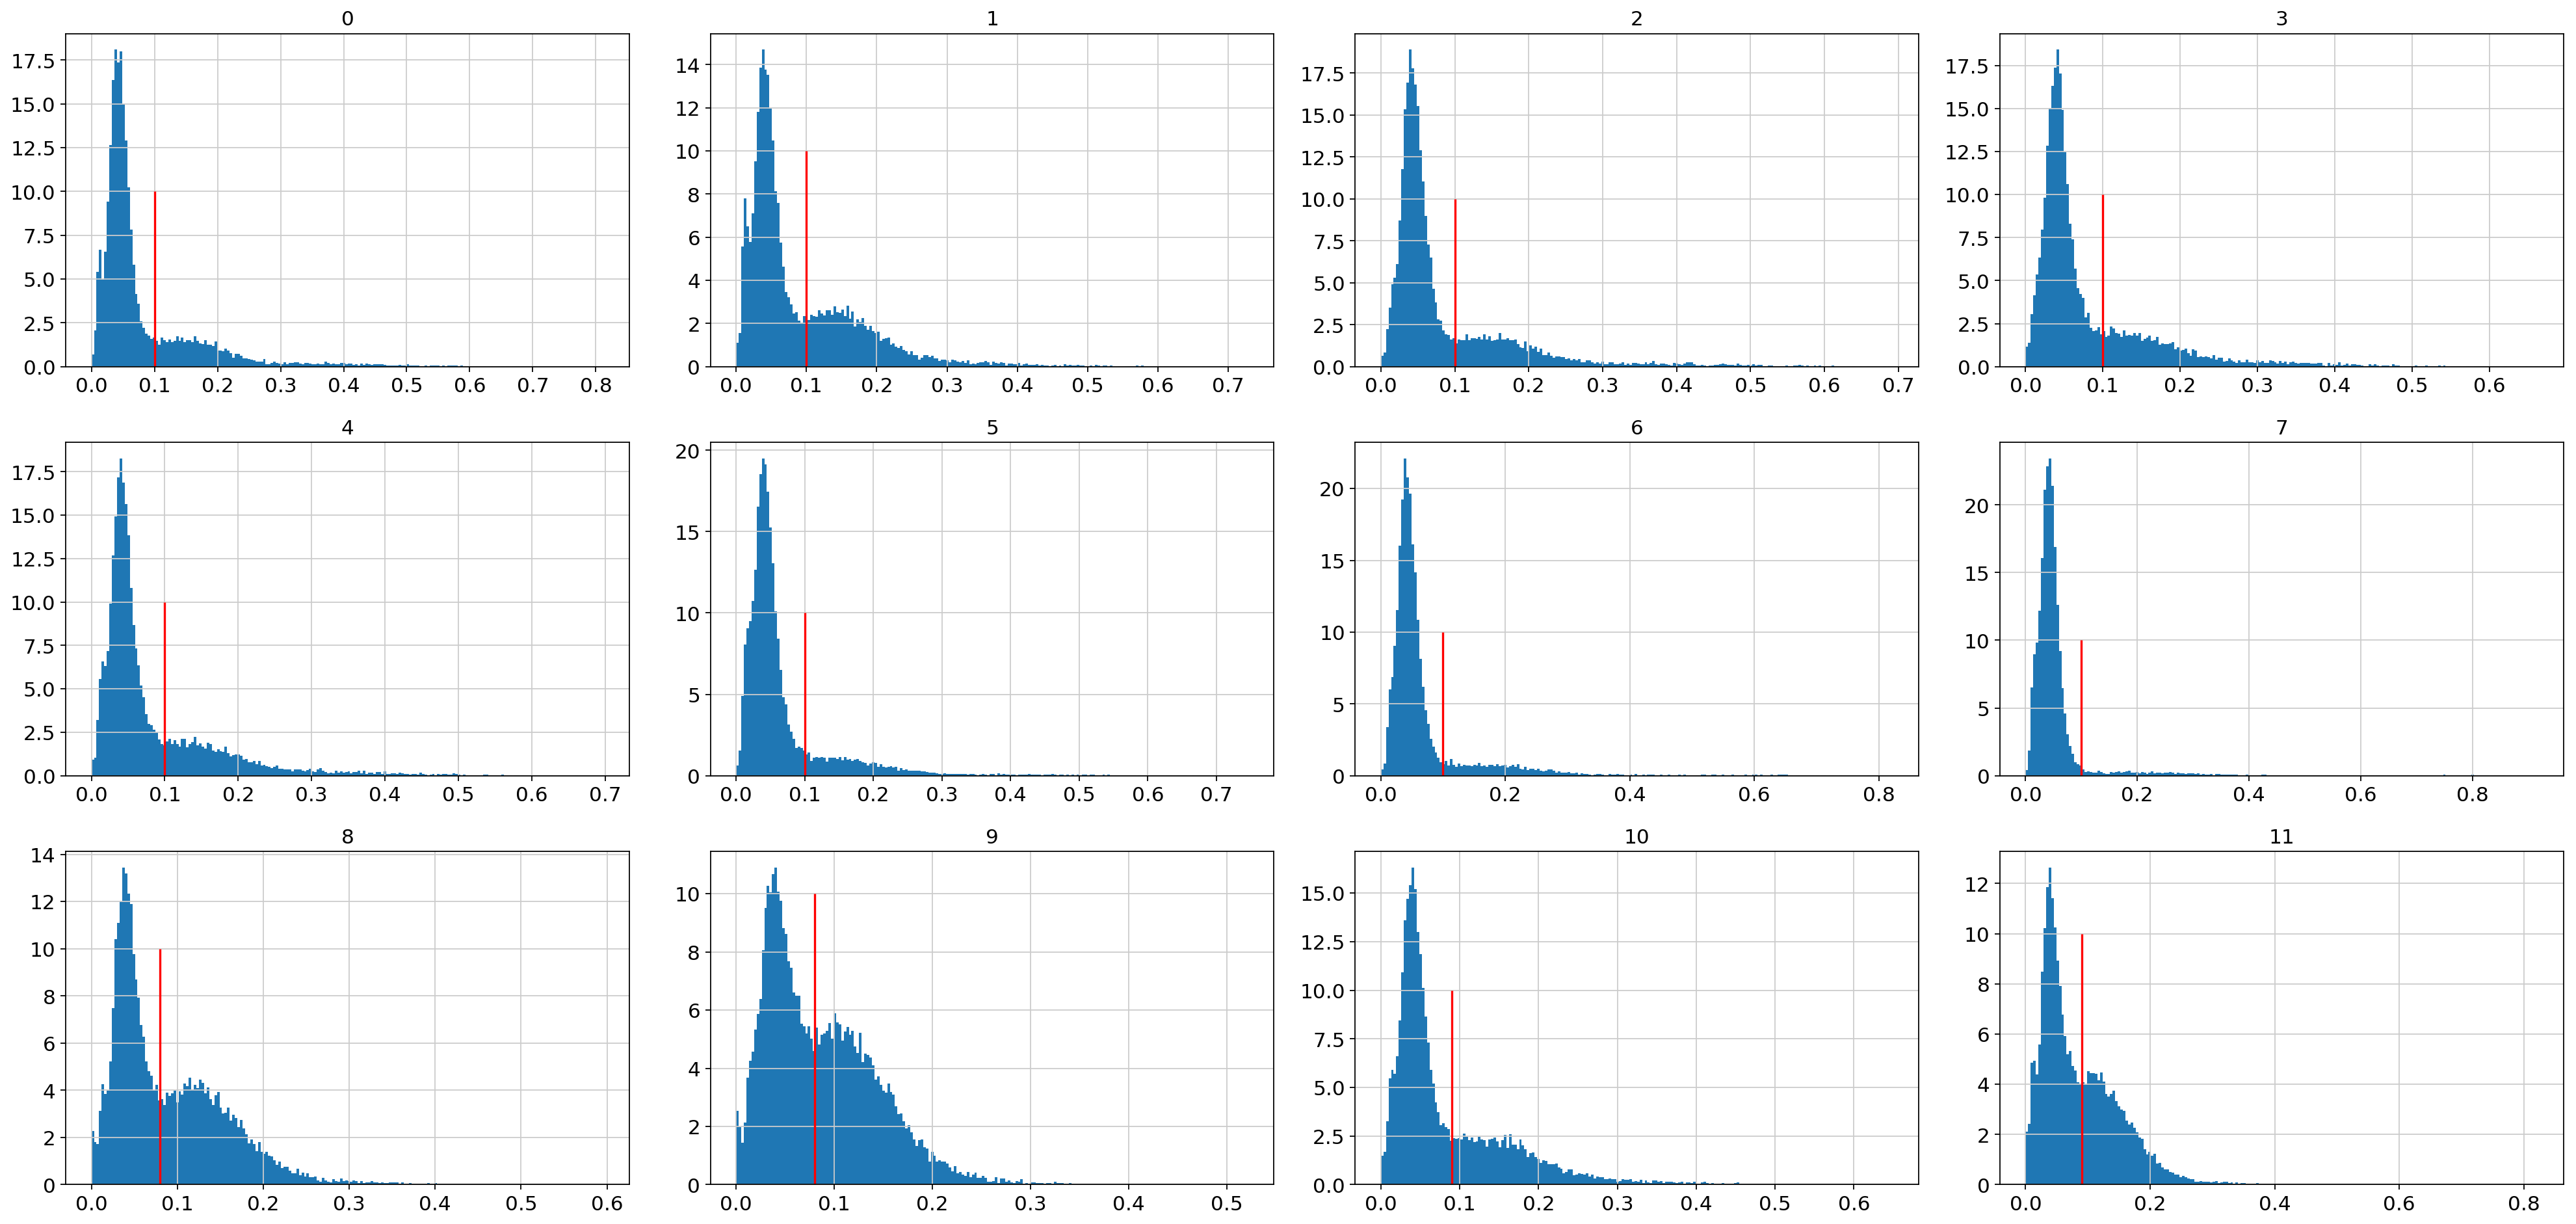

In [11]:
fig, ax = plt.subplots(3, 4, figsize=(25, 12))
for well, ax, cutoff in zip(wells, np.ravel(ax), cutoffs):
    ax.hist(wells[well]['adata'].obs['percent_mito'].values,bins=200,density=True);
    ax.set_title(well)
    ax.vlines(cutoff, 0, 10, color='r')
plt.tight_layout()

Just storing the percentage of cells that seem to have a high percentage of UMIs in mitochondrial genes.

In [12]:
for well, cutoff in zip(wells, cutoffs):
    wells[well]['percent_high_percent_mito'] = (wells[well]['adata'].obs['percent_mito'] > cutoff).sum()/wells[well]['adata'].shape[0]

In [12]:
path = prefix + 'pkls/wells.pkl'

# with open(path,'wb') as file:
#     pkl.dump(wells, file)
    
with open(path,'rb') as file:
    wells = pkl.load(file)

### Deconvolution

In [13]:
from nero import Harmonia
import seaborn as sns

In [14]:
for well in wells:
    wells[well]['freemux'] = Harmonia.MuxOut(prefix + "freemux.outs/well%d.samples.gz" % (well + 1))

In [15]:
deconvolution = pd.DataFrame(index=range(0,12), columns=[str(i) + 'f' for i in range(64)])

In [16]:
for i in tqdm(deconvolution.index):
    for c in deconvolution.columns:
        deconvolution.loc[i, c] = sum(wells[i]['freemux'].sng()['BEST.GUESS'] == c[:-1]) # up until -1 to avoid the f I added

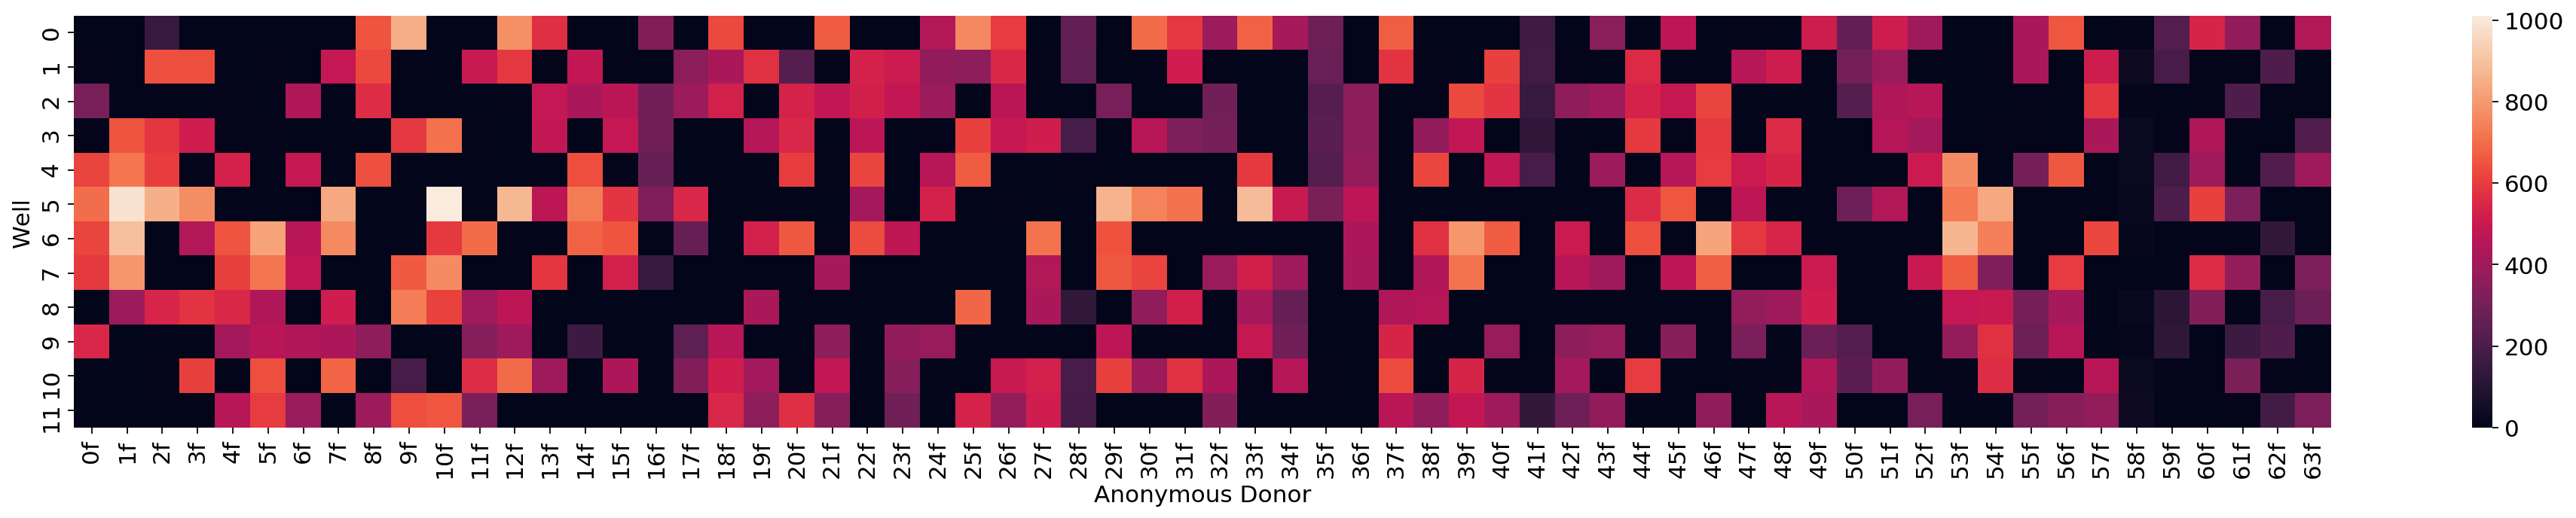

In [17]:
plt.figure(figsize=(30,4.5))
sns.heatmap(deconvolution);
plt.ylabel('Well')
plt.xlabel('Anonymous Donor');

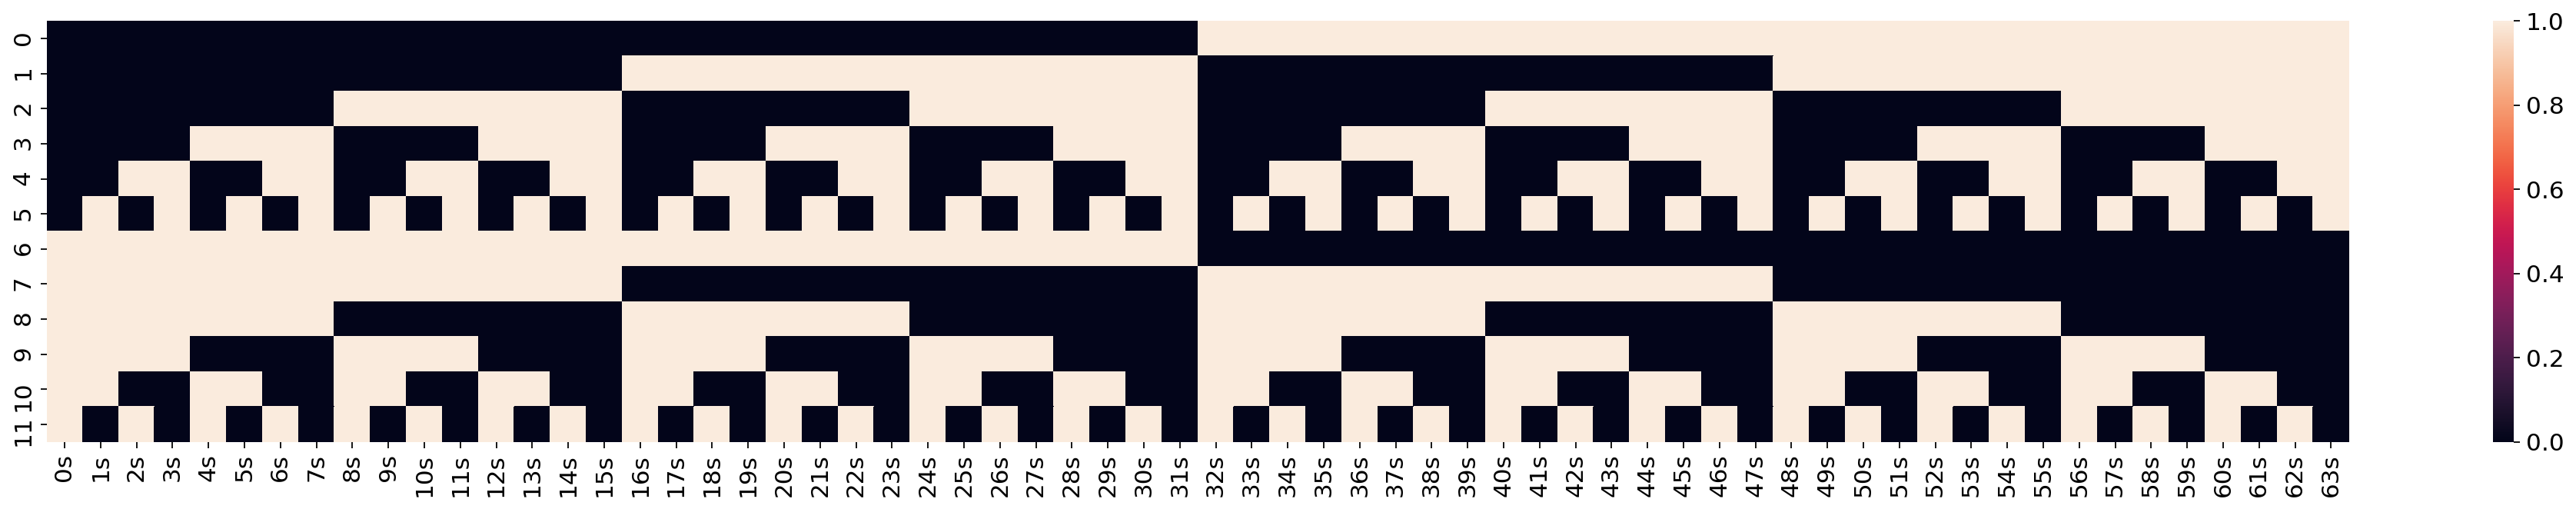

In [18]:
plt.figure(figsize=(30,4.5))
sns.heatmap(scheme != '0');

In [19]:
pool_codes_exp = dict()
pool_codes_exp_str = list()
for i in scheme.columns:
    pools = scheme[i][scheme[i] != '0'].index
    code = '-'.join(list(map(str,sorted(pools.tolist()))))
    pool_codes_exp[i] = code
    pool_codes_exp_str.append(code)
pool_codes_exp = {v: k for k, v in pool_codes_exp.items()}

In [20]:
pool_codes_free = dict()
pool_codes_free_str = list()
for i in deconvolution.columns:
    pools = deconvolution[i].sort_values(ascending=False)[:6].index
    code = '-'.join(list(map(str,sorted(pools.tolist()))))
    pool_codes_free[i] = code
    pool_codes_free_str.append(code)
pool_codes_free = {v: k for k, v in pool_codes_free.items()}

In [21]:
print(len(pool_codes_exp_str))
print(len(np.unique(pool_codes_exp_str)))

64
64


In [22]:
print(len(pool_codes_free_str))
print(len(np.unique(pool_codes_free_str)))

64
64


In [23]:
id_map_df = pd.DataFrame.from_dict(pool_codes_exp, orient='index', columns=['exp_id']).join(pd.DataFrame.from_dict(pool_codes_free, orient='index', columns=['free_id']))

In [24]:
id_map_df.iloc[5,:]

exp_id      5s
free_id    NaN
Name: 3-5-6-7-8-10, dtype: object

In [25]:
print([str(id_map_df.loc[row][0]) + ',' + str(id_map_df.loc[row][1]) for row in id_map_df.index])

['0s,5f', '1s,54f', '2s,4f', '3s,53f', '4s,27f', '5s,nan', '6s,38f', '7s,1f', '8s,42f', '9s,29f', '10s,6f', '11s,0f', '12s,39f', '13s,15f', '14s,46f', '15s,36f', '16s,11f', '17s,7f', '18s,62f', '19s,47f', '20s,19f', '21s,3f', '22s,48f', '23s,nan', '24s,23f', '25s,17f', '26s,40f', '27s,14f', '28s,57f', '29s,44f', '30s,20f', '31s,22f', '32s,49f', '33s,34f', '34s,56f', '35s,33f', '36s,9f', '37s,30f', '38s,63f', '39s,60f', '40s,21f', '41s,61f', '42s,43f', '43s,45f', '44s,32f', '45s,13f', '46s,52f', '47s,16f', '48s,37f', '49s,12f', '50s,55f', '51s,59f', '52s,28f', '53s,31f', '54s,25f', '55s,2f', '56s,18f', '57s,50f', '58s,8f', '59s,24f', '60s,26f', '61s,51f', '62s,41f', '63s,35f']


In [26]:
print(sorted([int(i[:-1]) for i in id_map_df['free_id'].dropna()]))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63]


Missing 10 and 58. Freemuxlet 10 is probably supposed to be 5, considering its only off by 1 from the 5 code and 5 is missing, which would leave 58 to be 23.

In [27]:
id_map_df['free_id'].iloc[5] = '10f'

In [28]:
id_map_df['free_id'].iloc[23] = '58f'

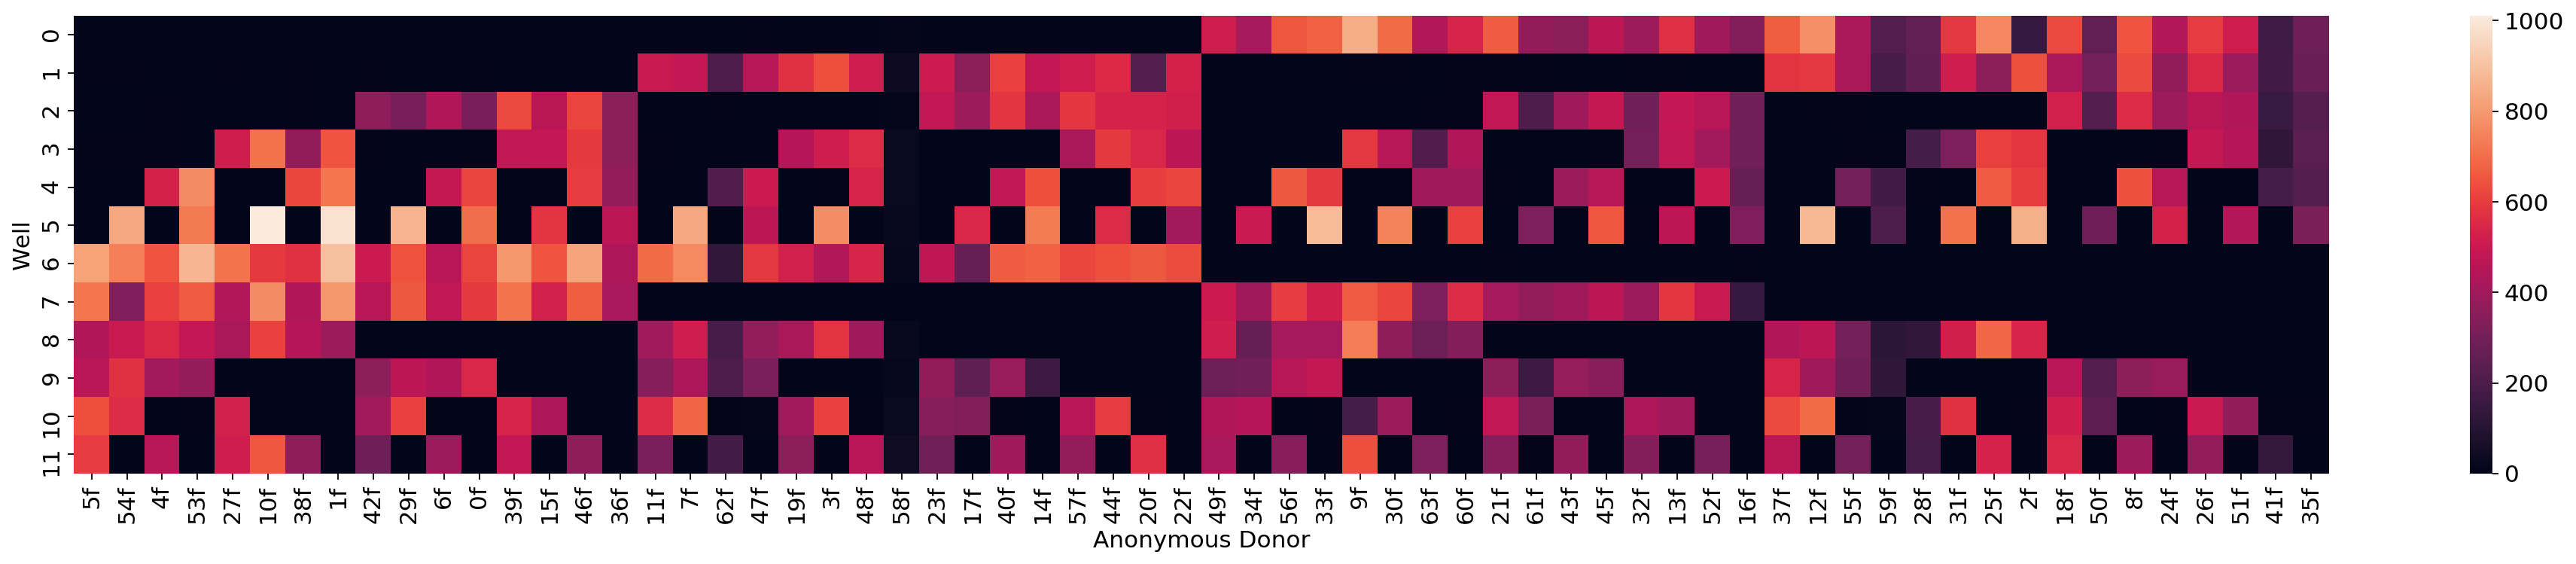

In [29]:
plt.figure(figsize=(30,5))
sns.heatmap(deconvolution[id_map_df['free_id'].values]);
plt.ylabel('Well')
plt.xlabel('Anonymous Donor');

### Investigating High Percent Mito

Trying to see if it can be explained by any of the expeirmental variables we have from †he day of the experiment.

#### Viability (Countess) of each pool just before loading:

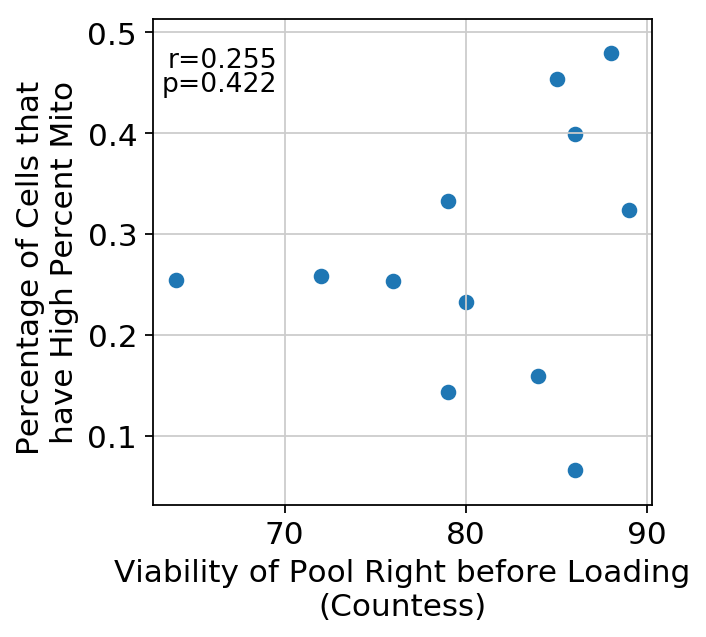

In [30]:
exp_viabilities = postpool[postpool['count_type'] == 'post_flowmi']['viability'].values
high_mitos = list(map(lambda well: wells[well]['percent_high_percent_mito'], range(12)))
plt.scatter(exp_viabilities, high_mitos);
r, p = pearsonr(exp_viabilities,high_mitos)
ax = plt.gca()
plt.text(0.25,0.9, 'r=' + str(r)[:5], size=12, transform=ax.transAxes, ha='right')
plt.text(0.25,0.85, 'p=' + str(p)[:5], size=12, transform=ax.transAxes, ha='right')
plt.ylabel('Percentage of Cells that \nhave High Percent Mito')
plt.xlabel('Viability of Pool Right before Loading\n(Countess)');

#### Average viability (FACS) of the samples that were destined for each pool right after stim incubation:

In [31]:
samps = dict()

In [32]:
for pool in scheme.index:
    samps[pool] = list()
    for ind in scheme.columns:
        if scheme.loc[pool,ind] != '0':
            samps[pool].append(str(ind) + '-' + scheme.loc[pool,ind])
            

In [33]:
mean_viablities = list()
for pool in range(12):
    counted = np.intersect1d(poststim.index.values, 
                             [i.replace('s','') for i in samps[pool]], # need to do this because I added an "s" to the IDs
                             assume_unique=True
                            )
    mean_viablities.append(poststim.loc[counted,:].mean()['viability'])

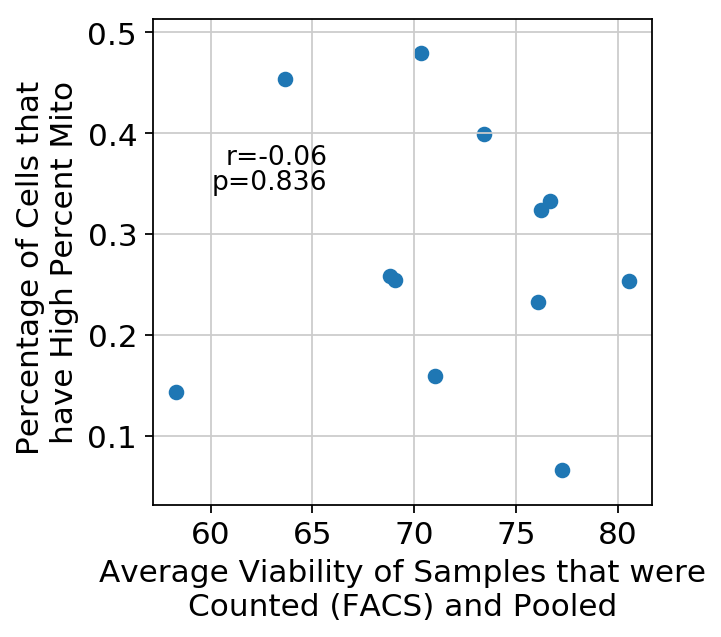

In [34]:
x = mean_viablities
y = list(map(lambda well: wells[well]['percent_high_percent_mito'], range(12)))
plt.scatter(x, y);
r, p = pearsonr(x,y)
ax = plt.gca()
plt.text(0.35,0.7, 'r=' + str(r)[:5], size=12, transform=ax.transAxes, ha='right')
plt.text(0.35,0.65, 'p=' + str(p)[:5], size=12, transform=ax.transAxes, ha='right')
plt.ylabel('Percentage of Cells that \nhave High Percent Mito')
plt.xlabel('Average Viability of Samples that were\nCounted (FACS) and Pooled');

### Plotting Conditions

Visualizing the number of cells per condition.

In [35]:
deconvolution = deconvolution[id_map_df['free_id'].values]

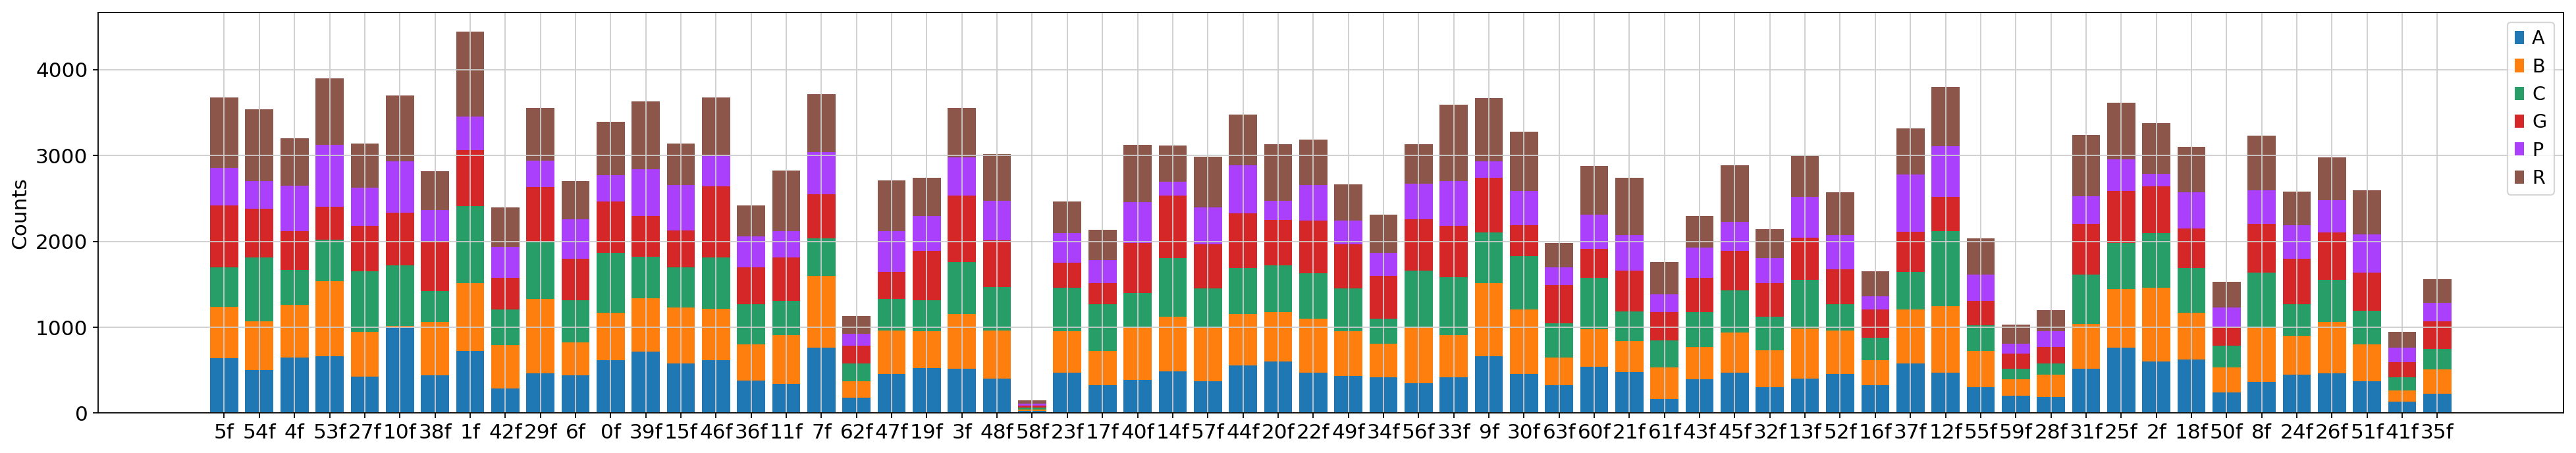

In [36]:
labels = deconvolution.columns.values
counts = dict()

for cond in conds:
    counts[cond] = deconvolution.values.T[(scheme==cond).values.T]

fig, ax = plt.subplots(figsize=(30,5))
lastpos = [0]*64
for cond in counts:
    ax.bar(labels, counts[cond], label=cond, bottom=lastpos)
    lastpos = counts[cond] + lastpos

ax.set_ylabel('Counts')
ax.legend()

plt.show()

In [37]:
keys, values = map(chain.from_iterable, zip(*((k*len(v), v) for k, v in counts.items())))
counts_df = pd.DataFrame({'cond': list(keys), 'count': list(values)})

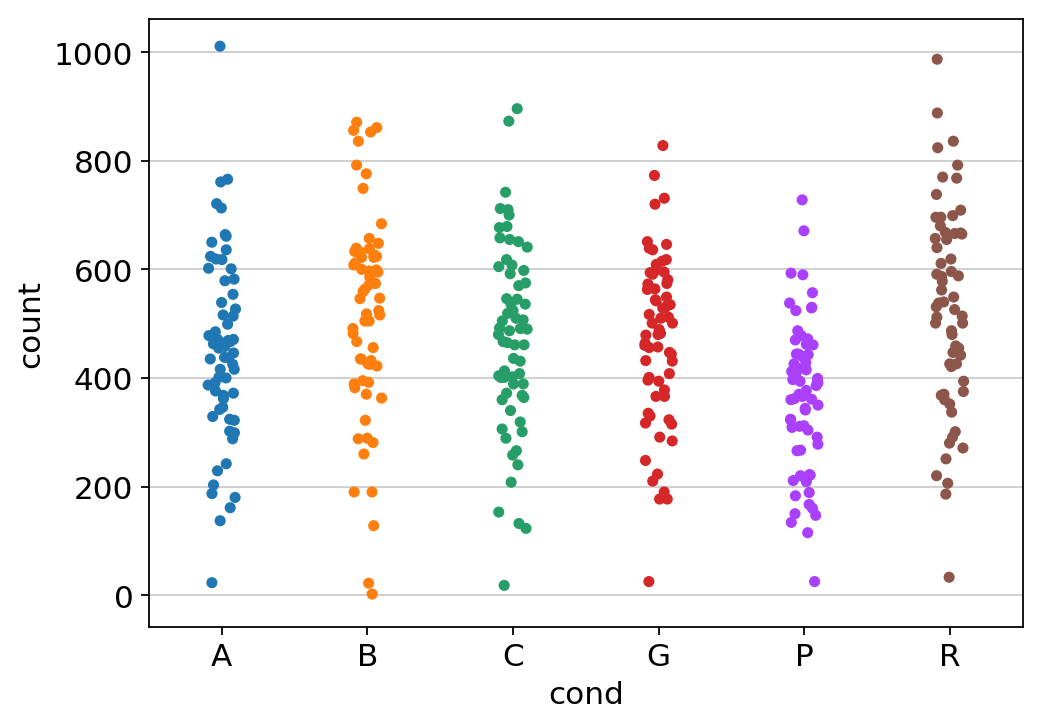

In [40]:
plt.figure(figsize=(7,5))
sns.stripplot(data=counts_df,x='cond',y='count');

### Investigating High Percent Mito, part 2

Checking to see if its also possibly due to overrepresentation of any one condition.

#### Percentage of cells in the pool from a given condition:

In [79]:
cond_count = pd.DataFrame(index=range(12),columns=conds)

In [80]:
for pool in tqdm(range(12)):
    for cond in conds:
        cond_count.loc[pool, cond] = deconvolution.loc[pool][(scheme==cond).values[pool]].sum()

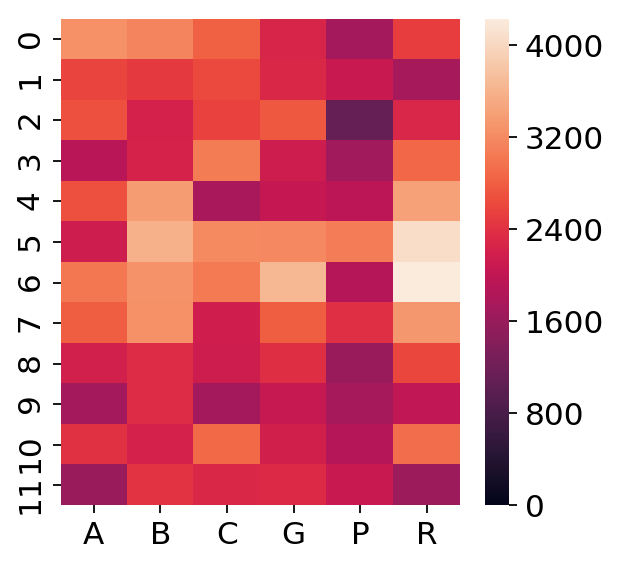

In [81]:
sns.heatmap(cond_count, vmin=0); 

In [82]:
cond_props = cond_count.divide(cond_count.sum(1), axis='index')

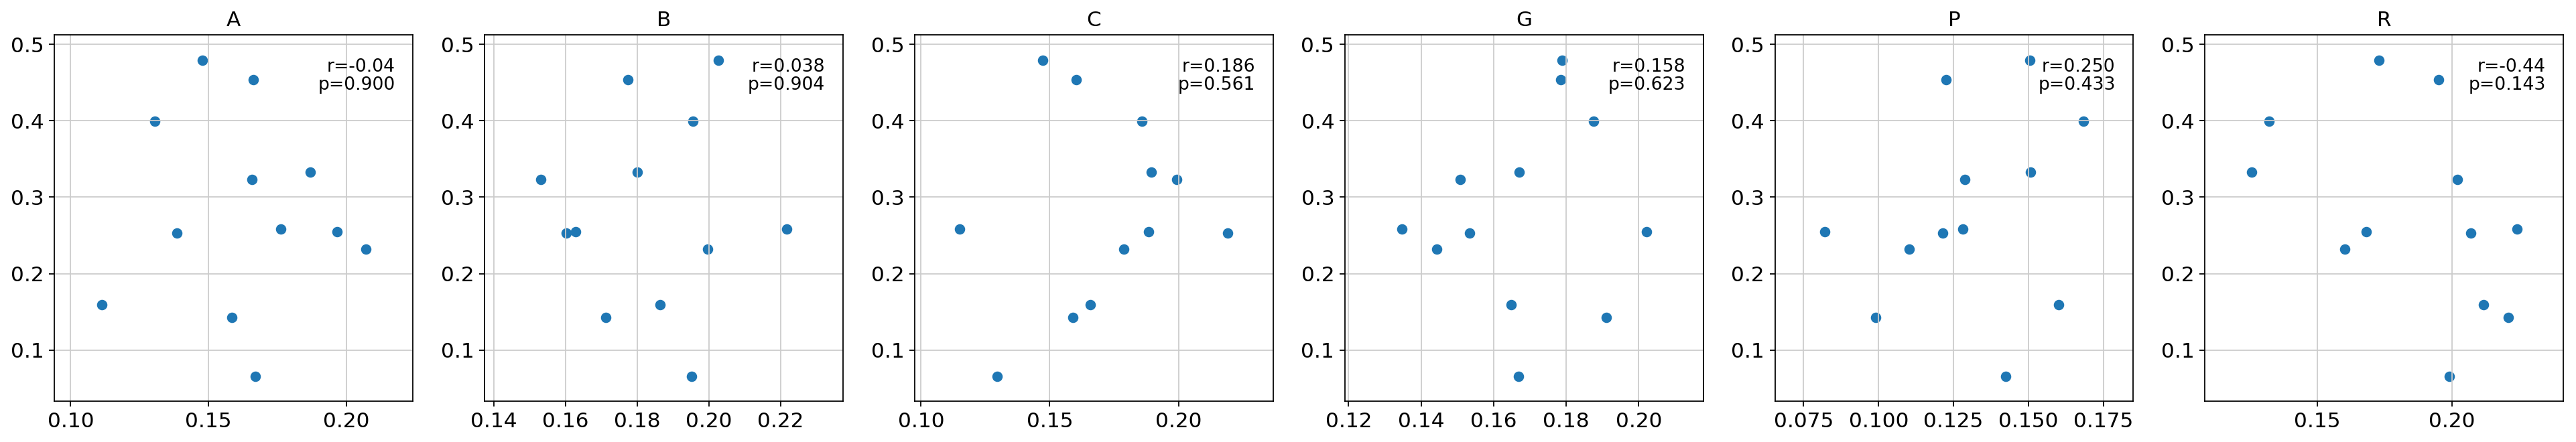

In [83]:
fig, ax = plt.subplots(1,6,figsize=(30,4.5))
for cond, ax in zip(conds, ax):
    x = cond_props[cond].values
    y = list(map(lambda well: wells[well]['percent_high_percent_mito'], range(12)))
    ax.scatter(x,y)
    ax.set_title(cond)
    r, p = pearsonr(x,y)
    ax.text(0.95,0.9, 'r=' + str(r)[:5], size=12, transform=ax.transAxes, ha='right')
    ax.text(0.95,0.85, 'p=' + str(p)[:5], size=12, transform=ax.transAxes, ha='right')

In [155]:
id_map_df['pool_code'] = id_map_df.index
id_map_df.set_index('free_id', inplace=True)
id_map_df.index = [i.strip('f') for i in id_map_df.index]

In [156]:
id_map_df['exp_id'] = id_map_df['exp_id'].str.replace('s','')

In [157]:
id_maps = dict()

In [159]:
for pool in scheme.index:
    cond_series = scheme.loc[pool]
    cond_series.index = cond_series.index.str.replace('s','')
    pool_df = id_map_df.copy()
    pool_df['cond'] = pool_df['exp_id'].map(dict(cond_series)).tolist()
    # proud of the next two lines
    pool_df['viability_sample'] = (pool_df['exp_id'] + '-' + pool_df['cond']).map(dict(zip(poststim.index,poststim['viability'])))
    pool_df['viability_eq_ctrl'] = (pool_df['exp_id'] + '-C').map(dict(zip(poststim.index,poststim['viability'])))
    id_maps[pool] = pool_df

In [160]:
for well in tqdm(wells):
    wells[well]['adata'] = Harmonia.ann_merge(wells[well]['adata'], wells[well]['freemux'].sng(), covars=id_maps[well])
    wells[well]['adata'].obs.columns = wells[well]['adata'].obs.columns.str.replace('BEST.GUESS','free_id')

In [164]:
for well in wells:
    print((wells[well]['adata'].obs['cond'] == 'C').sum())

2811
2623
2570
3057
1757
3191
3047
2170
2132
1712
2895
2308


In [165]:
path = prefix + 'pkls/wells.sng.w_covars.pkl'

# with open(path,'wb') as file:
#     pkl.dump(wells, file)
    
with open(path,'rb') as file:
    wells = pkl.load(file)